<a href="https://colab.research.google.com/github/jaimehdzgt/ETL-y-Aseguramiento-de-Calidad-de-Datos/blob/main/etl_cleaning_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto ETL End-to-End: Limpieza y Generación de Insights desde Datos Sucios

**Objetivo:** Convertir el dataset `etl_dirty_orders.xlsx` en una tabla confiable para análisis, documentando reglas de limpieza, validación y enriquecimiento; y entregar un dataset final + reporte de calidad + visualizaciones clave.

> **Instrucciones:** Coloca el archivo **`etl_dirty_orders.xlsx`** en la misma carpeta del notebook (o ajusta la variable `DATA_PATH`). El archivo incluye:
> - Hoja **`raw_orders`** (datos sucios)
> - Hoja **`lookup_states`** (normalización de estados)
> - Hoja **`lookup_subcats`** (corrección de subcategorías)


## 1) Configuración e importaciones

In [1]:

import os, re
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (8, 5)

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/datasets/etl_dirty_orders.xlsx'  # coloca el Excel junto al .ipynb
SHEET_RAW = 'raw_orders'
SHEET_STATES = 'lookup_states'
SHEET_SUBCATS = 'lookup_subcats'


## 2) Carga del dataset y snapshot inicial

In [2]:

assert os.path.exists(DATA_PATH), f'No se encontró {DATA_PATH}. Asegúrate de colocarlo en el mismo directorio del notebook.'
xls = pd.ExcelFile(DATA_PATH)
df = pd.read_excel(xls, SHEET_RAW)
lookup_states = pd.read_excel(xls, SHEET_STATES)
lookup_subcats = pd.read_excel(xls, SHEET_SUBCATS)

print('Forma inicial:', df.shape)
display(df.head(10))

nulls = df.isna().sum().sort_values(ascending=False)
types = df.dtypes
print('\nNulos por columna (top 15):'); display(nulls.head(15).to_frame('nulls'))
print('\nTipos detectados:'); display(types.to_frame('dtype'))


Forma inicial: (222, 31)


,Order ID,order id,Order_Date,Ship Date,CustomerName,customer email,Phone #,STATE,City,zip,Segment,ProductID,product name,Category,Sub-Category,Qty,Unit Price,discount %,TAX,Shipping,Order Priority,Payment_Method,Payment Date,order_status,PROFIT,TOTAL $,latitude,longitude,Address,Notes,TOTAL
0,10475,10475,2023-02-03,25-Aug-2023,Miguel Pérez,miguelprez@gmail.com,+52 (81) 922 6427,Ciudad de México,Guadalupe,14236.0,consumr,P-1653,Headset - Basic,Technology,Headset,4.0,"$4,730.17 MXN",10%,"3.027,31",99.88 pesos,Critical,Cash,03/04/23,Delivered,2648.9,20155.802000000003,25.120982,-99.223403,"Calle 137 #732, Col. Centro",Entregar sábado,NaN
1,11824,11824,26-Jan-2024,17/01/2024,Pedro García,pedrogarca@empresa.com,815748608,CDMX,Guadalajara,6470.0,Home Office,P-4240,Accessories - Max,Office Supplies,Accessories,-1.0,"$4.097,63 M.N",0%,$-655.62,539.18,Critical,PayPal,2023-01-10,Processing,MX$-614.64,-4214.07,25.791375,-99.338228,Av. Universidad 1877,NaN,-4214.07
2,15328,15328,24/01/2024,2022-01-01,Daniel Pérez,danielprez@gmail.com,+52 (81) 661 7121,Baja California,Guadalajara,31400.0,Home-Office,P-3238,Accessories - Plus,Technology,Accessories,5.0,$926.33 MXN,30%,741.06,$449.35 MXN,Medium,Transfer,03/10/2023,Delivered,NaN,"$4,432.57",25.764538,-99.090046,Av. Constitución 4457,NaN,NaN
3,13176,13176,01/29/23,08-Jun-2023,ana o'neil,anaoneil@mail.com,817089307,BCN,Zapopan,52143.0,consumr,P-7697,Copiers - Pro,Technology,Copiers,3.0,"$1,026.50",0.3,$492.72 MXN,NaN,Medium,Credit Card,04/10/24,Shipped,369.54,"$2,648.37",25.504549,-99.827441,Av. Revolución 4382,Entregar sábado,"$2,648.37"
4,15221,15221,05-Apr-2023,12/03/2023,ana de la cruz,anadelacruz@hotmail.com,81-875-4351,Ciudad de México,Querétaro,52584.0,Corporate,P-1694,Accessories - Mini,Office Supplies,Accessories,3.0,802.19,0.05,MXN $385.05,NaN,Critical,Cash,15.09.2023,Processing,NaN,2671.2915000000003,25.720201,-99.605849,"Calle 147 #609, Col. Centro",Revisar stock,NaN
5,17756,17756,28-Dec-2023,09/25/23,Miguel Martínez,miguelmartnez@empresa.com,816738235,Querétaro,Guadalupe,8133.0,Corporate,P-4193,Tables - Basic,Furniture,Tables,5.0,$775.13,5%,"$620,10",incluido,Low,Transfer,29.02.2024,Cancelled,561.97,4301.9675,25.728492,-99.786220,"Calle 49 #392, Col. Centro",Cliente VIP,NaN
6,18729,18729,2023-05-05,NaN,Daniel De la Cruz,danieldelacruz@mail.com,812 694 7547,Baja California,CDMX,5318.0,Home Office,P-4732,Binders - Max,Office Supplies,Binders,3.0,"$3,086.43",0,"MXN $1,481.49",134.89 pesos,Medium,Transfer,20.03.2022,Returned,1388.89,10875.669999999998,25.321663,-99.172552,"940 Priv. Las Flores,Depto 33",Entregar sábado,NaN
7,ORD-18244,ORD-18244,2023/10/29,2022-01-01,Ana López,analpez@outlook.com,+52 (81) 878 4793,NL,Guadalajara,64700.0,consumr,P-5136,Camras - Plus,Technology,Camras,0.0,MXN $799.44,30%,0.00,incluido,High,Credit Card,2024-02-07,Processing,0.0,0.0,25.763352,-99.393467,"387 Priv. Las Flores,Depto 9",Cliente VIP,NaN
8,19671,19671,06.01.2023,04-Jun-2023,Daniel De la Cruz,danieldelacruz@outlook.com,819229398,Baja California,San Nicolás,6470.0,Home-Office,P-4882,Paper - Plus,Office Supplies,Paper,5.0,"$4,526.19",0,"3,620.95",NaN,High,Transfer,06.04.2023,Shipped,MX$3394.64,"$26,251.90",25.805475,-99.086658,"Calle 30 #24, Col. Centro",NaN,"$26,251.90"
9,10609,10609,2023/01/02,30-Jan-2024,erika hernandez,erikahernandez@empresa.com,(81) 224-9770,Jalisco,Guadalajara,64700.0,Home Office,P-8175,Label - Max,Furniture,Label,4.0,"3,591.23",0,"$2,298.39",MXN $42.25,URGENTE,Transfer,04/16/23,Returned,MX$2154.74,"$16,705.56",25.176618,-99.960669,"918 Priv. Las Flores,Depto 7",Revisar stock,"$16,705.56"



Nulos por columna (top 15):


,nulls
TOTAL,183
Notes,94
Shipping,64
PROFIT,58
Ship Date,34
Payment Date,24
order id,8
ProductID,2
City,2
zip,2



Tipos detectados:


,dtype
Order ID,object
order id,object
Order_Date,object
Ship Date,object
CustomerName,object
customer email,object
Phone #,object
STATE,object
City,object
zip,float64



## 3) Estandarización de esquema (nombres y columnas duplicadas)

- Normalizamos encabezados a `snake_case` y trim de espacios.
- Resolución de columnas duplicadas/solapadas (por ejemplo: `TOTAL $` vs `TOTAL`). Guardamos **una** columna final y documentamos la decisión.


In [3]:

def normalize_colname(c: str) -> str:
    c = c.strip()
    c = c.replace('%','_pct').replace('$','_usd').replace('#','num')
    c = re.sub(r'[^0-9a-zA-Z]+', '_', c)
    c = re.sub(r'__+', '_', c).strip('_')
    return c.lower()

df.columns = [normalize_colname(c) for c in df.columns]

# Unificar TOTAL si existe variante
if 'total_usd' in df.columns and 'total' in df.columns:
    df['total'] = df['total'].fillna(df['total_usd'])
    df.drop(columns=['total_usd'], inplace=True, errors='ignore')

# Unificar posibles duplicados de order_id
dup_cols = [c for c in df.columns if c.startswith('order_id') and c != 'order_id']
for c in dup_cols:
    df['order_id'] = df['order_id'].fillna(df[c]) if 'order_id' in df.columns else df[c]
    df.drop(columns=[c], inplace=True, errors='ignore')

print('Columnas tras normalización:', list(df.columns))


Columnas tras normalización: ['order_id', 'order_id', 'order_date', 'ship_date', 'customername', 'customer_email', 'phone_num', 'state', 'city', 'zip', 'segment', 'productid', 'product_name', 'category', 'sub_category', 'qty', 'unit_price', 'discount_pct', 'tax', 'shipping', 'order_priority', 'payment_method', 'payment_date', 'order_status', 'profit', 'latitude', 'longitude', 'address', 'notes', 'total']



## 4) Limpieza de filas no-datos (SUBTOTAL / TOTAL GENERAL)

Removemos filas que son subtotales o totales incrustadas en el cuerpo de la tabla.


In [4]:

# Eliminar filas "SUBTOTAL / TOTAL GENERAL" aunque existan columnas duplicadas o el valor esté en cualquier columna
tokens = {"SUBTOTAL", "TOTAL GENERAL", "TOTAL_GENERAL"}

before = df.shape[0]
mask_bad = df.astype(str).apply(lambda s: s.str.strip().str.upper().isin(tokens)).any(axis=1)
df = df[~mask_bad].copy()
after = df.shape[0]

print(f"Filas removidas (no-datos): {before - after}")



Filas removidas (no-datos): 2



## 5) Tipos y formatos (fechas, moneda, porcentajes)

- **Fechas:** múltiples formatos → parseo robusto.
- **Moneda:** normalizamos a `float` (admite `$`, `MXN`, comas como separador decimal y miles).
- **Porcentajes:** unificamos a fracción (0–1).


In [5]:
import re
import numpy as np
import pandas as pd

# -----------------------------
# 1) Fechas (sin warnings)
# -----------------------------
def parse_date_series(s: pd.Series) -> pd.Series:
    """Parsea fechas de forma robusta y sin warnings.
    Soporta: ISO (YYYY-MM-DD / YYYY/MM/DD), MDY, DMY, años cortos y seriales de Excel.
    """
    # Intentos ordenados por probabilidad / claridad (evitamos dayfirst/infer)
    YEAR_FIRST = ["%Y-%m-%d", "%Y/%m/%d", "%Y.%m.%d"]
    MDY        = ["%m/%d/%Y", "%m-%d-%Y", "%m.%d.%Y", "%m/%d/%y", "%m-%d-%y"]
    DMY        = ["%d/%m/%Y", "%d-%m-%Y", "%d.%m.%Y", "%d/%m/%y", "%d-%m-%y"]

    def parse_excel_serial(n):
        # Serial de Excel (base 1899-12-30). Usamos un rango razonable para evitar timestamps.
        try:
            n = float(n)
        except Exception:
            return pd.NaT
        if 20000 <= n <= 60000:  # ~1954-2024 aprox.
            return pd.to_datetime(n, unit="D", origin="1899-12-30", errors="coerce")
        return pd.NaT

    def try_formats(txt, fmts):
        for fmt in fmts:
            dt = pd.to_datetime(txt, format=fmt, errors="coerce")
            if not pd.isna(dt):
                return dt
        return pd.NaT

    def _parse_one(x):
        if pd.isna(x):
            return pd.NaT

        # Numérico: intentamos serial de Excel
        if isinstance(x, (int, float)) and not pd.isna(x):
            dt = parse_excel_serial(x)
            if not pd.isna(dt):
                return dt

        # Texto
        t = str(x).strip()
        if t == "" or t.lower() == "none":
            return pd.NaT

        # Si parece número, intenta serial Excel
        if re.fullmatch(r"[-+]?\d+(\.\d+)?", t or ""):
            dt = parse_excel_serial(t)
            if not pd.isna(dt):
                return dt

        # 1) ISO / year-first (no ambiguo)
        dt = try_formats(t, YEAR_FIRST)
        if not pd.isna(dt):
            return dt

        # 2) Mes/Día/Año
        dt = try_formats(t, MDY)
        if not pd.isna(dt):
            return dt

        # 3) Día/Mes/Año
        dt = try_formats(t, DMY)
        if not pd.isna(dt):
            return dt

        return pd.NaT

    return s.apply(_parse_one)

# -----------------------------
# 2) Moneda
# -----------------------------
money_regex = re.compile(r"[^0-9,.-]")

def parse_money_series(s: pd.Series) -> pd.Series:
    def _to_float(x):
        if pd.isna(x):
            return np.nan
        t = str(x).strip()
        if t.lower() in {"n/a", "na", "incluido", ""}:
            return 0.0 if t.lower() == "incluido" else np.nan
        t = money_regex.sub("", t)
        # Manejo de separadores , .
        if t.count(",") > 0 and t.count(".") > 0:
            # Si la última coma va después del último punto, asumimos coma decimal EU
            t = t.replace(".", "").replace(",", ".") if t.rfind(",") > t.rfind(".") else t.replace(",", "")
        else:
            # Solo coma: úsala como decimal
            t = t.replace(",", ".") if t.count(",") == 1 and t.count(".") == 0 else t.replace(",", "")
        try:
            return float(t)
        except ValueError:
            return np.nan
    return s.apply(_to_float)

# -----------------------------
# 3) Porcentajes
# -----------------------------
def parse_percent_series(s: pd.Series) -> pd.Series:
    def _pct(x):
        if pd.isna(x):
            return np.nan
        t = str(x).strip().replace("%", "")
        try:
            v = float(t)
        except ValueError:
            return np.nan
        return v/100 if v > 1 else (v if 0 <= v <= 1 else np.nan)
    return s.apply(_pct)

# -----------------------------
# Aplicación al DataFrame
# -----------------------------
for col in ["order_date", "ship_date", "payment_date"]:
    if col in df.columns:
        df[col] = parse_date_series(df[col])

for col in ["unit_price", "tax", "shipping", "profit", "total"]:
    if col in df.columns:
        df[col] = parse_money_series(df[col])

for col in ["discount_pct", "discount"]:
    if col in df.columns:
        df[col] = parse_percent_series(df[col])

# Consolidación de discount_pct
if "discount_pct" in df.columns and "discount" in df.columns:
    df["discount_pct"] = df["discount_pct"].fillna(df["discount"])
    df.drop(columns=["discount"], inplace=True, errors="ignore")
elif "discount" in df.columns and "discount_pct" not in df.columns:
    df.rename(columns={"discount": "discount_pct"}, inplace=True)



## 6) Limpieza general de texto

- `strip()` de espacios, normalización de mayúsculas/minúsculas donde aplique.
- Columnas objetivo: nombres, ciudad, estado, email, teléfono, categoría, subcategoría, segmento, dirección.


In [6]:

def trim_str(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().replace({'': np.nan})

rename_map = {
    'phone': 'phone_num',
    'customer_email': 'email',
    'customername': 'customer_name',
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

# Limpieza básica de texto
cols_clean = [c for c in ['customer_name','email','phone_num','state','city','category',
                          'sub_category','segment','address','order_priority',
                          'payment_method','order_status','product_name'] if c in df.columns]
for c in cols_clean:
    df[c] = trim_str(df[c])

# Normaliza espacios y capitalización (usa raw string para regex)
for c in ['customer_name','state','city','category','sub_category','segment',
          'order_status','order_priority','payment_method']:
    if c in df.columns:
        df[c] = df[c].str.replace(r'\s+', ' ', regex=True).str.title()

# Emails en minúsculas
if 'email' in df.columns:
    df['email'] = df['email'].str.lower()




## 7) Normalización de estados y subcategorías (lookups)

- Unificamos variantes de **estado** usando `lookup_states`.
- Corregimos **typos de subcategoría** con `lookup_subcats`.
- Unificamos valores de **segmento** (e.g., `Home-Office` → `Home Office`, `Consumr` → `Consumer`).


In [7]:

# Estados  (usa raw strings r'\s+' para evitar el SyntaxWarning)
import re

if {'state_variant','state_clean'}.issubset(lookup_states.columns):
    lk = lookup_states.copy()
    lk['state_variant_norm'] = (
        lk['state_variant']
        .astype(str).str.strip().str.title()
        .str.replace(r'\s+', ' ', regex=True)   # <- raw string
    )
    state_map = dict(zip(lk['state_variant_norm'], lk['state_clean']))
    if 'state' in df.columns:
        state_norm = (
            df['state']
            .astype(str).str.strip().str.title()
            .str.replace(r'\s+', ' ', regex=True)  # <- raw string
        )
        df['state'] = state_norm.map(state_map).fillna(state_norm)

# Subcategorías
if {'dirty_subcategory','clean_subcategory'}.issubset(lookup_subcats.columns):
    sub_map = dict(
        zip(
            lookup_subcats['dirty_subcategory'].astype(str).str.title(),
            lookup_subcats['clean_subcategory']
        )
    )
    if 'sub_category' in df.columns:
        df['sub_category'] = df['sub_category'].replace(sub_map)

# Segmento
if 'segment' in df.columns:
    df['segment'] = df['segment'].replace({'Home-Office': 'Home Office', 'Consumr': 'Consumer'})




## 8) Reglas de integridad de negocio

- `ship_date >= order_date` y `payment_date >= order_date` → marcamos excepciones.
- `qty` mínimo 1; tratamos 0/negativos como inválidos y los reportamos.
- Recalculamos `total_calc = (unit_price * qty) * (1 - discount_pct) + tax + shipping` (shipping nulo → 0).
- **Flag** si `total` reportado difiere de `total_calc`.


In [8]:

if 'qty' in df.columns:
    df['qty'] = pd.to_numeric(df['qty'], errors='coerce')

df['flag_ship_before_order'] = False
df['flag_payment_before_order'] = False
if {'ship_date','order_date'}.issubset(df.columns):
    df['flag_ship_before_order'] = (df['ship_date'] < df['order_date']) & df['ship_date'].notna() & df['order_date'].notna()
if {'payment_date','order_date'}.issubset(df.columns):
    df['flag_payment_before_order'] = (df['payment_date'] < df['order_date']) & df['payment_date'].notna() & df['order_date'].notna()

if 'shipping' in df.columns:
    df['shipping'] = df['shipping'].fillna(0.0)
if 'discount_pct' in df.columns:
    df['discount_pct'] = df['discount_pct'].fillna(0.0)

for col in ['unit_price','qty','tax','shipping','discount_pct']:
    if col not in df.columns:
        df[col] = 0.0

df['total_calc'] = (df['unit_price'] * df['qty']) * (1 - df['discount_pct']) + df['tax'].fillna(0) + df['shipping'].fillna(0)

if 'total' in df.columns:
    df['flag_total_discrepancy'] = (np.round(df['total'],2) != np.round(df['total_calc'],2))
else:
    df['total'] = df['total_calc']
    df['flag_total_discrepancy'] = False

df['flag_qty_invalid'] = df['qty'].fillna(0) <= 0
print('Resumen flags:')
display(df[['flag_ship_before_order','flag_payment_before_order','flag_total_discrepancy','flag_qty_invalid']].sum())


Resumen flags:


,0
flag_ship_before_order,62
flag_payment_before_order,82
flag_total_discrepancy,112
flag_qty_invalid,16



## 9) Geodatos: detección de lat/long intercambiados

- Asumimos México: latitudes entre ~14 y 33, longitudes entre ~-118 y -86.
- Si detectamos coordenadas fuera de rango pero su inversión cae en rango, **intercambiamos**.


In [9]:

def fix_latlon(row):
    lat, lon = row.get('latitude', np.nan), row.get('longitude', np.nan)
    if pd.isna(lat) or pd.isna(lon):
        return lat, lon, False
    def in_mx(a, b):
        return (14 <= a <= 33) and (-118 <= b <= -86)
    ok = in_mx(lat, lon)
    swapped_ok = in_mx(lon, lat)
    if (not ok) and swapped_ok:
        return lon, lat, True
    return lat, lon, False

if {'latitude','longitude'}.issubset(df.columns):
    fixed = df.apply(fix_latlon, axis=1, result_type='expand')
    df[['latitude','longitude','flag_latlon_swapped']] = fixed
    print('Coordenadas corregidas (swaps):', int(df['flag_latlon_swapped'].sum()))


Coordenadas corregidas (swaps): 19



## 10) Duplicados

- Definimos llave de granularidad (`order_id`, `productid`, `order_date` si existen).
- Eliminamos duplicados conservando la primera ocurrencia y reportamos el impacto.


In [10]:

# Duplicados (robusto aunque haya columnas duplicadas con el mismo nombre)
import pandas as pd

keys_wanted = ['order_id', 'productid', 'order_date']

def first_series_by_name(df, name):
    """Devuelve la PRIMERA columna (Series) cuyo nombre == name, aunque existan duplicadas."""
    idxs = [i for i, c in enumerate(df.columns) if c == name]
    return df.iloc[:, idxs[0]] if idxs else None

# Construimos un DataFrame auxiliar con llaves sin nombres repetidos
aux_cols = {}
keys_present = []
for k in keys_wanted:
    s = first_series_by_name(df, k)
    if s is not None:
        aux_cols[k] = s
        keys_present.append(k)

before = df.shape[0]
if keys_present:
    df_keys = pd.DataFrame(aux_cols, index=df.index)

    # Orden estable con las llaves (equivale a df.sort_values(keys), pero sin ambigüedad)
    order_idx = df_keys.sort_values(by=keys_present, kind='mergesort').index

    # Marca duplicados sobre el df_keys (no tiene columnas duplicadas)
    dup_mask = df_keys.loc[order_idx].duplicated(subset=keys_present, keep='first')

    # Filtra el df original respetando el orden calculado
    df = df.loc[order_idx][~dup_mask].copy()

after = df.shape[0]
print(f'Duplicados eliminados: {before - after}')



Duplicados eliminados: 0



## 11) Reporte de calidad (antes/después por regla)

Generamos un pequeño panel con:
- Nulos por columna
- Conteo de flags
- Filas afectadas por cada regla


In [11]:

quality = {}
quality['nulls_total'] = int(df.isna().sum().sum())

for flag in ['flag_ship_before_order','flag_payment_before_order','flag_total_discrepancy','flag_qty_invalid','flag_latlon_swapped']:
    if flag in df.columns:
        quality[flag] = int(df[flag].sum())

quality_df = pd.DataFrame({'metric': list(quality.keys()), 'value': list(quality.values())})
print('Resumen de calidad:'); display(quality_df)

OUT_CSV = 'fact_orders_clean.csv'
OUT_QUALITY = 'quality_report.csv'
df.to_csv(OUT_CSV, index=False)
quality_df.to_csv(OUT_QUALITY, index=False)
print(f'Archivos exportados: {OUT_CSV}, {OUT_QUALITY}')


Resumen de calidad:


,metric,value
0,nulls_total,336
1,flag_ship_before_order,62
2,flag_payment_before_order,82
3,flag_total_discrepancy,112
4,flag_qty_invalid,16
5,flag_latlon_swapped,19


Archivos exportados: fact_orders_clean.csv, quality_report.csv



## 12) Insights rápidos (visualizaciones)

- Ventas (total_calc) por categoría
- Margen (profit) por categoría
- Distribución de descuento efectivo


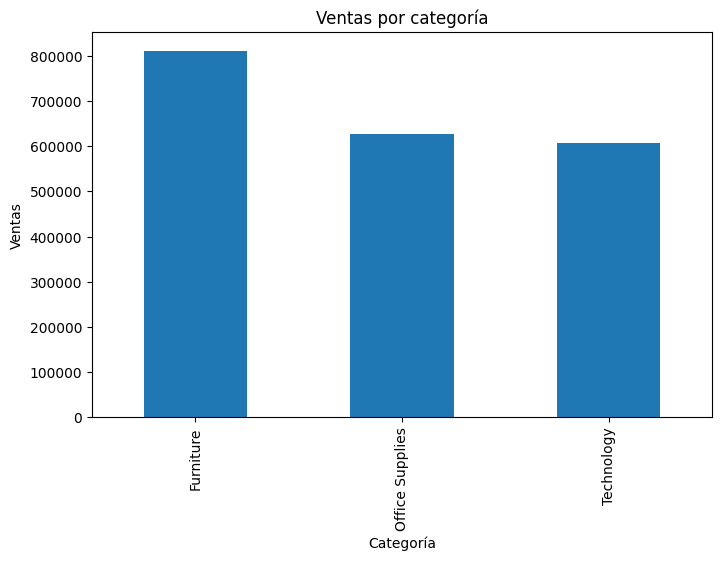

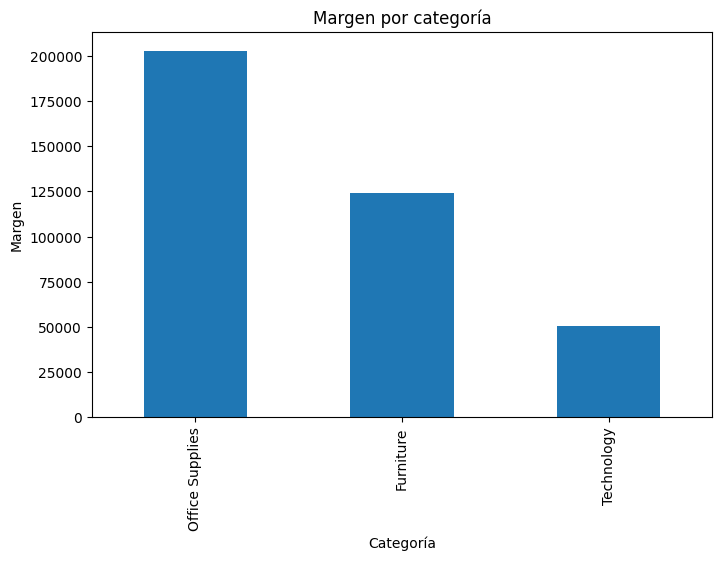

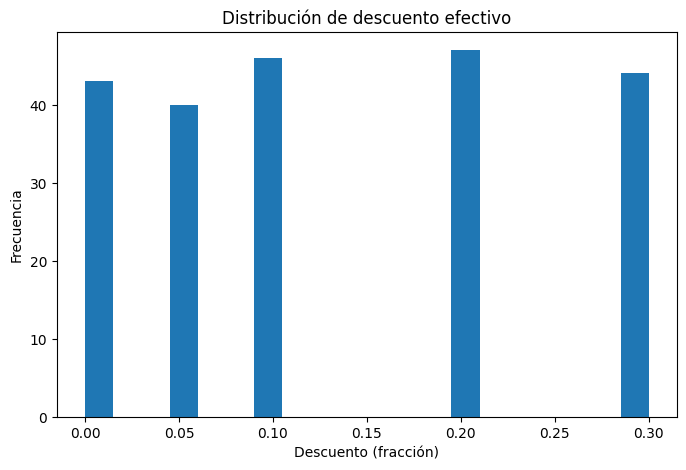

In [12]:

for col in ['total_calc','category','profit','discount_pct','qty']:
    if col not in df.columns:
        df[col] = np.nan

sales_cat = df.groupby('category', dropna=False)['total_calc'].sum().sort_values(ascending=False)
sales_cat.plot(kind='bar', title='Ventas por categoría')
plt.xlabel('Categoría'); plt.ylabel('Ventas'); plt.show()

if 'profit' in df.columns:
    profit_cat = df.groupby('category', dropna=False)['profit'].sum().sort_values(ascending=False)
    profit_cat.plot(kind='bar', title='Margen por categoría')
    plt.xlabel('Categoría'); plt.ylabel('Margen'); plt.show()

df['discount_pct'].dropna().plot(kind='hist', bins=20, title='Distribución de descuento efectivo')
plt.xlabel('Descuento (fracción)'); plt.ylabel('Frecuencia'); plt.show()


## 13) Vista previa del dataset limpio

In [13]:

display(df.head(10))
print('Forma final:', df.shape)


,order_id,order_id,order_date,ship_date,customer_name,email,phone_num,state,city,zip,segment,productid,product_name,category,sub_category,qty,unit_price,discount_pct,tax,shipping,order_priority,payment_method,payment_date,order_status,profit,latitude,longitude,address,notes,total,flag_ship_before_order,flag_payment_before_order,total_calc,flag_total_discrepancy,flag_qty_invalid,flag_latlon_swapped
192,10217,10217,2023-08-30,2023-12-04,Sofía López,sofalpez@outlook.com,(81) 578-6692,Ciudad de México,Tijuana,57229.0,Consumer,P-3285,Storage - Max,Furniture,Storage,4.0,1053.36,0.10,674.15,0.00,Urgente,Transfer,2022-12-07,Processing,589.88,25.450769,-99.460788,"614 Priv. Las Flores,Depto 22",Revisar stock,4466.246,False,True,4466.246,False,False,False
200,10220,10220,2023-09-29,2023-12-04,Miguel López,miguellpez@empresa.com,81-289-9316,Nuevo León,Apodaca,6470.0,Consumer,P-9692,Phones - Pro,Technology,Phones,4.0,3173.46,0.10,2031.01,63.50,Low,Debit Card,2022-11-26,Returned,1777.14,25.394668,-99.163960,Av. Revolución 2438,Cliente VIP,13518.970,False,True,13518.966,False,False,False
142,10326,10326,NaT,2023-03-31,Jaime Gómez,jaimegmez@outlook.com,+52 (81) 851 5825,Ciudad de México,Querétaro,64700.0,Corporate,P-2453,Copiers - Pro,Technology,Copiers,2.0,4597.96,0.10,1471.35,0.00,Urgente,Transfer,NaT,Delivered,1287.43,25.220895,-99.434450,Av. Revolución 737,Cliente VIP,9747.678,False,False,9747.678,False,False,False
88,10447,10447,NaT,NaT,Daniel Ramírez,danielramrez@gmail.com,81-757-5331,Nuevo León,Zapopan,7533.0,Home Office,P-9704,Phones - XL,Technology,Phones,5.0,1440.81,0.10,1152.65,0.00,Urgente,Debit Card,NaT,Processing,1008.57,25.262625,-99.469558,"695 Priv. Las Flores,Depto 21",NaN,7636.300,False,False,7636.295,False,False,False
0,10475,10475,2023-02-03,NaT,Miguel Pérez,miguelprez@gmail.com,+52 (81) 922 6427,Ciudad de México,Guadalupe,14236.0,Consumer,P-1653,Headset - Basic,Technology,Headsets,4.0,4730.17,0.10,3027.31,99.88,Critical,Cash,2023-03-04,Delivered,2648.90,25.120982,-99.223403,"Calle 137 #732, Col. Centro",Entregar sábado,20155.802,False,False,20155.802,False,False,False
47,10606,10606,2023-08-14,2023-11-10,Jaime Rodriguez,jaimerodriguez@mail.com,812 835 1732,Ciudad de México,Guadalupe,76445.0,Consumer,P-7686,Copiers - Mini,Technology,Copiers,1.0,1418.41,0.30,226.95,571.98,Urgente,Credit Card,2022-11-30,Cancelled,170.21,25.829138,-99.318984,"26 Priv. Las Flores,Depto 21",Cliente VIP,1791.820,False,True,1791.817,False,False,True
116,10609,NaN,2023-12-18,2022-01-01,María Martínez,maramartnez@hotmail.com,81-757-1349,Jalisco,San Nicolás,6470.0,Consumer,P-4898,Tables - Plus,Furniture,Tables,4.0,1886.51,0.30,1207.37,0.00,Medium,Debit Card,2022-06-01,Shipped,905.52,25.277275,-99.015972,"Calle 139 #257, Col. Centro",NaN,6489.600,True,True,6489.598,False,False,False
9,10609,10609,2023-01-02,NaT,Erika Hernandez,erikahernandez@empresa.com,(81) 224-9770,Jalisco,Guadalajara,64700.0,Home Office,P-8175,Label - Max,Furniture,Labels,4.0,3591.23,0.00,2298.39,42.25,Urgente,Transfer,2023-04-16,Returned,2154.74,25.176618,-99.960669,"918 Priv. Las Flores,Depto 7",Revisar stock,16705.560,False,False,16705.560,False,False,False
115,10653,10653,NaT,2022-01-01,Mónica De La Cruz,mnicadelacruz@mail.com,(81) 509-9785,Nuevo León,Santa Catarina,3925.0,Consumer,P-4228,Chairs - XL,Furniture,Chairs,4.0,4870.49,0.05,64862.00,0.00,Low,Oxo,2024-01-17,Processing,2824.88,25.606209,-99.488577,"Calle 148 #195, Col. Centro",NaN,18507.860,False,False,83369.862,True,False,False
167,10750,10750,NaT,NaT,Pedro Gómez,pedrogmez@mail.com,812 720 6273,Baja California,Querétaro,45860.0,Home Office,P-6657,Camras - Basic,Technology,Cameras,2.0,978.34,0.20,313.07,494.73,High,Cash,NaT,Delivered,254.37,25.700014,-99.251573,"Calle 180 #561, Col. Centro",Revisar stock,2323.144,False,False,2373.144,True,False,False


Forma final: (220, 36)


In [14]:
# === Resumen compacto de insights (a partir del df limpio) ===
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

def has(c): return c in df.columns
def pick(cands): return next((c for c in cands if has(c)), None)
def as_num(name):
    if name is None: return pd.Series(dtype=float)
    return pd.to_numeric(df[name], errors='coerce')

# --- Mapeo flexible de columnas (según tu proyecto) ---
sales_col   = pick(['total_calc','total','Sales','sales'])
profit_col  = pick(['profit','Profit'])
seg_col     = pick(['segment','Segment'])
region_col  = pick(['region','Region'])
state_col   = pick(['state','State'])
cat_col     = pick(['category','Category'])
subcat_col  = pick(['sub_category','Sub_Category','subcategory'])
shipmode_col= pick(['ship_mode','Ship_Mode','payment_method','order_priority'])
order_col   = pick(['order_date','Order_Date'])
ship_col    = pick(['ship_date','Ship_Date'])
status_col  = pick(['order_status','status'])

# --- Series numéricas limpias ---
s_sales  = as_num(sales_col)
s_profit = as_num(profit_col)

# --- KPIs globales ---
rows = len(df)
total_sales  = s_sales.sum()  if not s_sales.empty else np.nan
total_profit = s_profit.sum() if not s_profit.empty else np.nan
margin = (total_profit/total_sales) if (pd.notna(total_sales) and total_sales not in (0,np.nan)) else np.nan
profitable_rate = (s_profit > 0).mean() if not s_profit.empty else np.nan

# --- Segmentos / geografía / categorías ---
seg_counts   = (df[seg_col].value_counts(dropna=False) if seg_col else pd.Series(dtype=int))
seg_profit   = (s_profit.groupby(df[seg_col]).sum().sort_values(ascending=False) if (seg_col and not s_profit.empty) else pd.Series(dtype=float))
region_profit= (s_profit.groupby(df[region_col]).sum().sort_values(ascending=False) if (region_col and not s_profit.empty) else pd.Series(dtype=float))
state_profit = (s_profit.groupby(df[state_col]).sum().sort_values(ascending=False) if (state_col and not s_profit.empty) else pd.Series(dtype=float))
cat_sales    = (s_sales.groupby(df[cat_col]).sum().sort_values(ascending=False) if (cat_col and not s_sales.empty) else pd.Series(dtype=float))
cat_profit   = (s_profit.groupby(df[cat_col]).sum().sort_values(ascending=False) if (cat_col and not s_profit.empty) else pd.Series(dtype=float))
sub_profit   = (s_profit.groupby(df[subcat_col]).sum().sort_values(ascending=False) if (subcat_col and not s_profit.empty) else pd.Series(dtype=float))

# --- Logística (proxy si no hay ship_mode) ---
ship_counts  = (df[shipmode_col].value_counts(dropna=False) if shipmode_col else pd.Series(dtype=int))
ship_profit  = (s_profit.groupby(df[shipmode_col]).sum().sort_values(ascending=False) if (shipmode_col and not s_profit.empty) else pd.Series(dtype=float))

# --- Extras opcionales ---
returns_rate = None
if status_col:
    returns_rate = (df[status_col].astype(str).str.strip().str.title() == 'Returned').mean()

lead_mean = lead_median = None
if order_col and ship_col:
    lead = (df[ship_col] - df[order_col]).dt.days
    lead_mean, lead_median = float(lead.mean(skipna=True)), float(lead.median(skipna=True))

# --- Helpers de formato ---
fmt = lambda x: "—" if (x is None or (isinstance(x,float) and np.isnan(x))) else (f"{x:,.2f}" if isinstance(x,(float,np.floating)) else f"{x:,}" if isinstance(x,(int,np.integer)) else str(x))
pct = lambda x: "—" if (x is None or (isinstance(x,float) and np.isnan(x))) else f"{100*x:.2f}%"

# --- Picks para el texto ---
seg_top_count = f"{seg_counts.index[0]} ({int(seg_counts.iloc[0])})" if not seg_counts.empty else "—"
seg_top_profit= f"{seg_profit.index[0]}" if not seg_profit.empty else "—"
region_top_profit = f"{region_profit.index[0]}" if not region_profit.empty else "—"
states_top = ", ".join(list(state_profit.head(3).index)) if not state_profit.empty else "—"
cat_top_sales = f"{cat_sales.index[0]}" if not cat_sales.empty else "—"
cat_top_profit= f"{cat_profit.index[0]}" if not cat_profit.empty else "—"
subs_top = ", ".join(list(sub_profit.head(3).index)) if not sub_profit.empty else "—"
ship_top_mode = f"{ship_counts.index[0]} ({int(ship_counts.iloc[0])})" if not ship_counts.empty else "—"
ship_top_profit= f"{ship_profit.index[0]}" if not ship_profit.empty else "—"

# --- Construcción del resumen tipo “executive summary” ---
lines = []

lines.append("## 🧭 Resumen Ejecutivo — Pedidos (dataset limpio)")
lines.append("")
lines.append(f"- **Órdenes**: **{fmt(rows)}**")
if not s_sales.empty:
    lines.append(f"- **Ventas totales**: **{fmt(total_sales)}**")
if not s_profit.empty:
    lines.append(f"- **Utilidad total**: **{fmt(total_profit)}**")
if not np.isnan(margin):
    lines.append(f"- **Margen global (Profit/Total)**: **{pct(margin)}**")
if not np.isnan(profitable_rate):
    lines.append(f"- **Tasa de órdenes rentables**: **{pct(profitable_rate)}**")

lines.append("\n### 1) Clientes & Segmentos")
lines.append(f"- Segmento con más órdenes: **{seg_top_count}**")
lines.append(f"- Segmento con mayor utilidad total: **{seg_top_profit}**")

lines.append("\n### 2) Geografía")
lines.append(f"- Región más rentable (utilidad): **{region_top_profit}**")
lines.append(f"- Estados top por utilidad: **{states_top}**")

lines.append("\n### 3) Categorías & Productos")
lines.append(f"- Categoría con mayor participación en ventas: **{cat_top_sales}**")
lines.append(f"- Categoría con mayor utilidad: **{cat_top_profit}**")
lines.append(f"- Subcategorías top por utilidad: **{subs_top}**")

lines.append("\n### 4) Logística")
lines.append(f"- Modalidad más utilizada: **{ship_top_mode}**")
lines.append(f"- Modalidad más rentable: **{ship_top_profit}**")

if returns_rate is not None:
    lines.append("\n### 5) Devoluciones")
    lines.append(f"- Tasa de devoluciones: **{pct(returns_rate)}**")

if (lead_mean is not None) and (lead_median is not None):
    lines.append("\n### 6) Lead time")
    lines.append(f"- Promedio: **{fmt(lead_mean)} días** | Mediana: **{fmt(lead_median)} días**")

lines.append("\n### 7) Recomendaciones rápidas")
lines.append("- **Portafolio**: potenciar categorías/subcategorías top; revisar SKUs con baja contribución o pérdidas.")
lines.append("- **Precios/Descuentos**: evaluar ajustes en regiones/estados con menor rentabilidad.")
lines.append("- **Logística**: si alguna modalidad es poco rentable, considerar fees mínimos o políticas diferenciadas.")
lines.append("- **Calidad de datos**: monitorear discrepancias `total` vs `total_calc` y fechas fuera de secuencia.")

display(Markdown("\n".join(lines)))


## 🧭 Resumen Ejecutivo — Pedidos (dataset limpio)

- **Órdenes**: **220**
- **Ventas totales**: **2,046,387.60**
- **Utilidad total**: **377,532.15**
- **Margen global (Profit/Total)**: **18.45%**
- **Tasa de órdenes rentables**: **68.18%**

### 1) Clientes & Segmentos
- Segmento con más órdenes: **Home Office (84)**
- Segmento con mayor utilidad total: **Corporate**

### 2) Geografía
- Región más rentable (utilidad): **—**
- Estados top por utilidad: **Ciudad de México, Jalisco, Bcn**

### 3) Categorías & Productos
- Categoría con mayor participación en ventas: **Furniture**
- Categoría con mayor utilidad: **Office Supplies**
- Subcategorías top por utilidad: **Staplers, Labels, Bookcases**

### 4) Logística
- Modalidad más utilizada: **Paypal (44)**
- Modalidad más rentable: **Paypal**

### 5) Devoluciones
- Tasa de devoluciones: **20.00%**

### 6) Lead time
- Promedio: **-71.62 días** | Mediana: **8.00 días**

### 7) Recomendaciones rápidas
- **Portafolio**: potenciar categorías/subcategorías top; revisar SKUs con baja contribución o pérdidas.
- **Precios/Descuentos**: evaluar ajustes en regiones/estados con menor rentabilidad.
- **Logística**: si alguna modalidad es poco rentable, considerar fees mínimos o políticas diferenciadas.
- **Calidad de datos**: monitorear discrepancias `total` vs `total_calc` y fechas fuera de secuencia.